In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,max_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 1000, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        mae = max_error(Y_unscaled,predicted_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("MAE unscaled: ",mae)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('Combined_all_3rd.csv', encoding='cp1252')     

In [6]:
data.columns.values

array(['Name', 'Coef_a', 'Coef_b', 'Coef_c', 'Coef_d', 'A_site', 'B_site',
       'X_site', 'Spacegroup', 'Ehull', 'BulkModulus', 'Energy', 'ZPE',
       's_A', 's_B', 's_X', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X',
       'mean_X2X', 'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh',
       'TF', 'OF', 'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G',
       'X_G', 'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII',
       'A_EA', 'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA',
       'X_ChiA', 'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc',
       'A_Ra', 'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP',
       'X_BP', 'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf',
       'X_Hf', 'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa',
       'A_CvM', 'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [7]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup', 'Ehull','BulkModulus', 'Energy','s_A','s_B','s_X','Coef_a','Coef_b', 'Coef_d'], axis=1, inplace = True)

In [8]:
data.fillna(0, inplace= True)
#sg_dummies = pd.get_dummies(data.Spacegroup)
#d = pd.concat([data, sg_dummies], axis=1)
#d.drop(['Spacegroup'], axis=1, inplace=True)

In [9]:
d=data.copy()
d.columns.values

array(['Coef_c', 'ZPE', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X',
       'mean_X2X', 'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh',
       'TF', 'OF', 'A_Z', 'B_Z', 'X_Z', 'A_M', 'B_M', 'X_M', 'A_G', 'B_G',
       'X_G', 'A_IEI', 'B_IEI', 'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII',
       'A_EA', 'B_EA', 'X_EA', 'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA',
       'X_ChiA', 'A_Rvdw', 'B_Rvdw', 'X_Rvdw', 'A_Rc', 'B_Rc', 'X_Rc',
       'A_Ra', 'B_Ra', 'X_Ra', 'A_MP', 'B_MP', 'X_MP', 'A_BP', 'B_BP',
       'X_BP', 'A_Rho', 'B_Rho', 'A_MV', 'B_MV', 'X_MV', 'A_Hf', 'B_Hf',
       'X_Hf', 'A_Hv', 'B_Hv', 'X_Hv', 'A_Kappa', 'B_Kappa', 'X_Kappa',
       'A_CvM', 'B_CvM', 'X_CvM', 'A_B', 'B_B', 'X_B', 'A_MendeleevNo',
       'B_MendeleevNo', 'X_MendeleevNo'], dtype=object)

In [10]:
columns = list(d.columns.values)

# Standard Scaling

In [11]:
data_std=d.copy()
scaler=StandardScaler()
scaler.fit(np.array(data['ZPE']).reshape(-1, 1))
data_zpe_std= scaler.transform(np.array(data['ZPE']).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std['ZPE'] 
X = data_std.drop(['ZPE'], axis=1)

In [12]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [13]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'X_Ra', 'A_Hf', 'X_Rc', 'B_BP', 'mean_A2B', 'A_BP', 'B_M', 'A_Ra', 'B_Hv', 'X_MendeleevNo', 'X_B', 'A_MendeleevNo', 'A_M', 'X_CvM', 'X_MP', 'X_M', 'X_ChiA', 'A_MV', 'A_Rc', 'X_IEII', 'X_Hv', 'X_BP', 'A_Hv', 'X_Hf'}


In [14]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape

(80, 51)

### Test-train splitting 

In [15]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state =50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop('ZPE')
X = df_train

Y_test = df_test.pop('ZPE')
X_test = df_test

RF 0.9513970663385419
RMSE:  0.2240607074672554
RMSE unscaled:  2.626574953457106
MAE unscaled:  5.744511266216605
----------------------------------------


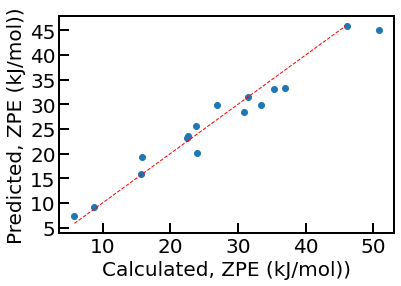

GB 0.8214699955076975
RMSE:  0.429427713799344
RMSE unscaled:  5.034011050556643
MAE unscaled:  15.244161874889144
----------------------------------------


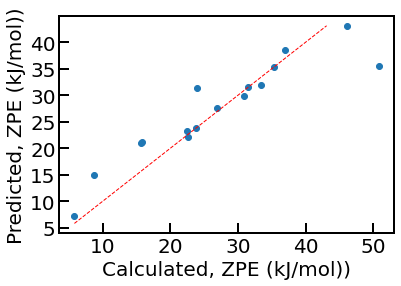

LR 0.9654193000141585
RMSE:  0.1889954509361602
RMSE unscaled:  2.2155188357547964
MAE unscaled:  4.509745270473545
----------------------------------------


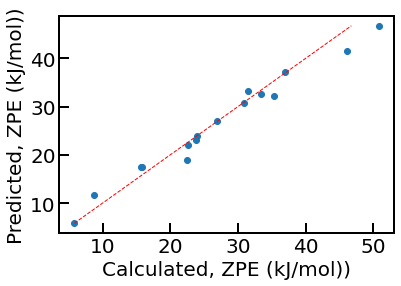

RR 0.9710651152637821
RMSE:  0.17288023302694677
RMSE unscaled:  2.0266065172661594
MAE unscaled:  4.684509673859893
----------------------------------------


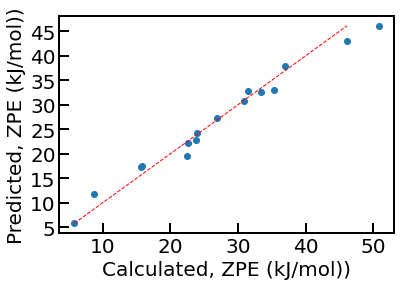

LASSO 0.9674377281151402
RMSE:  0.183396823826654
RMSE unscaled:  2.1498883470100263
MAE unscaled:  4.728636193931045
----------------------------------------


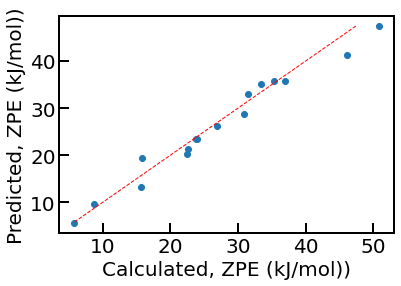

gpr1 0.9725018905714405
RMSE:  0.1685333598495499
RMSE unscaled:  1.975649844216853
MAE unscaled:  4.84833888637349
----------------------------------------


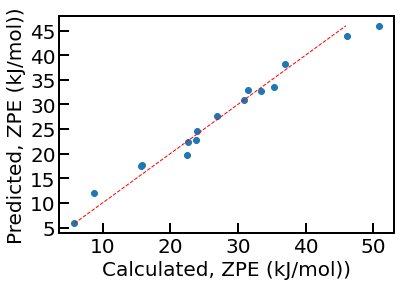

gpr2 0.9666690530472488
RMSE:  0.1855488585990847
RMSE unscaled:  2.1751157985169405
MAE unscaled:  4.170268917353447
----------------------------------------


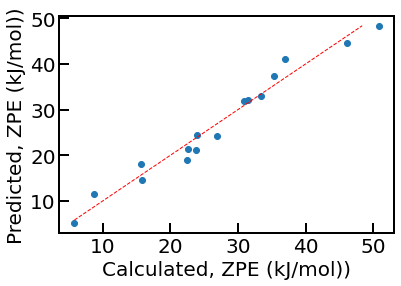

gpr3 0.9666690381511304
RMSE:  0.1855489000614149
RMSE unscaled:  2.1751162845634195
MAE unscaled:  4.170269215593635
----------------------------------------


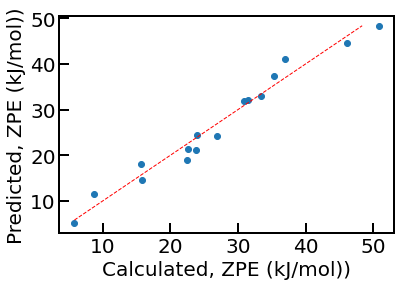

gpr4 0.9661791458533973
RMSE:  0.18690750779635318
RMSE unscaled:  2.1910427050790893
MAE unscaled:  4.21649739942233
----------------------------------------


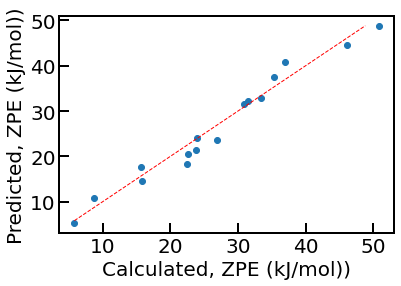

gpr5 0.9678378817405513
RMSE:  0.18226647025595327
RMSE unscaled:  2.136637659681069
MAE unscaled:  4.063859026654626
----------------------------------------


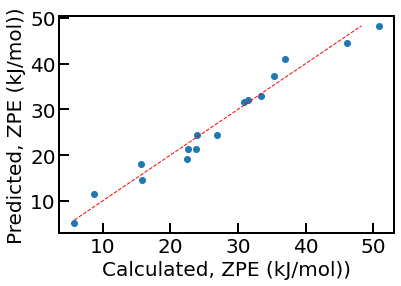

gpr6 0.864836434225095
RMSE:  0.37364939307481637
RMSE unscaled:  4.380143882961662
MAE unscaled:  13.130620088606797
----------------------------------------


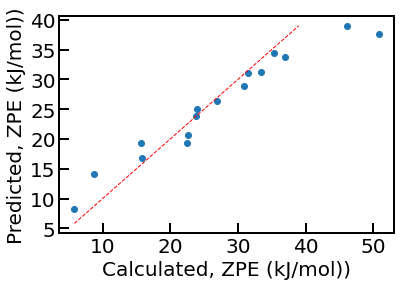

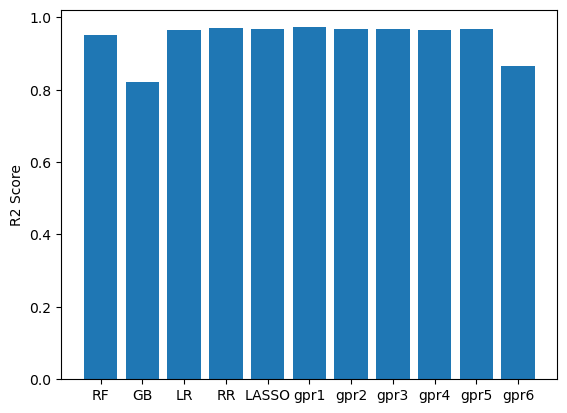

In [16]:
run_models()

In [17]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
25      X_EA  92.731602
0     Coef_c  78.453631
32    X_Rvdw  78.252722
14       X_Z  56.410866
4   mean_X2X  30.227587
17       X_G  27.028217
30    A_Rvdw  25.470189
18     A_IEI  20.253029
2   mean_A2X  20.187025
41      B_Hf  16.502777
13       B_Z  15.285802
7    std_B2X  13.488784
34      B_Ra  13.013335
29    A_ChiA  12.911391
9      E_coh  12.906501
11        OF  12.359339
23      A_EA  12.040753
6    std_A2X  11.184092
26    A_ChiP   9.894678
36      B_MP   9.555513
38     B_Rho   8.828042
46     B_CvM   7.511897
10        TF   6.732381
42   A_Kappa   6.485563
35      A_MP   6.292825
40      X_MV   5.978844
33      B_Rc   5.532563
31    B_Rvdw   5.346255
8    std_X2X   4.906579
5    std_A2B   4.709590


In [18]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'Coef_c', 'X_Rvdw', 'X_Z', 'mean_X2X', 'X_G', 'A_Rvdw',
       'A_IEI', 'mean_A2X', 'B_Hf', 'B_Z', 'std_B2X', 'B_Ra', 'A_ChiA',
       'E_coh', 'OF', 'A_EA', 'std_A2X', 'A_ChiP', 'B_MP', 'B_Rho',
       'B_CvM', 'TF', 'A_Kappa', 'A_MP', 'X_MV', 'B_Rc', 'B_Rvdw',
       'std_X2X', 'std_A2B'], dtype=object)

In [19]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9528149793551539
RMSE:  0.22076820962131505
RMSE unscaled:  2.587978304922813
MAE unscaled:  5.498255963499965
----------------------------------------


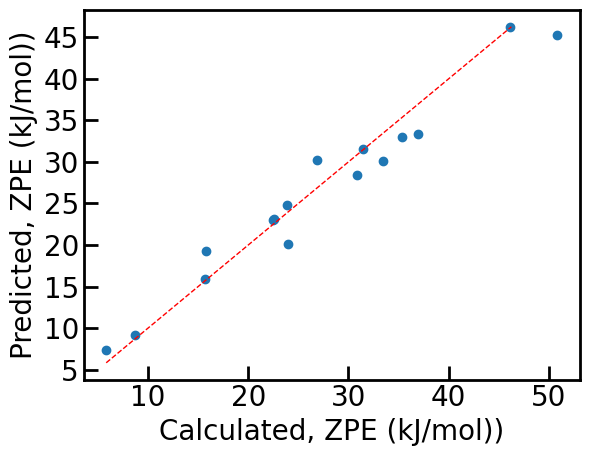

GB 0.7624116501738287
RMSE:  0.49538976717286193
RMSE unscaled:  5.807258083594787
MAE unscaled:  17.305699658968003
----------------------------------------


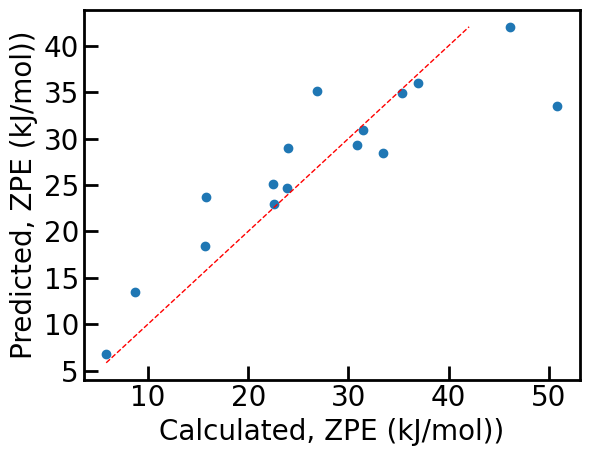

LR 0.9602102523283284
RMSE:  0.202730949052296
RMSE unscaled:  2.376534641394755
MAE unscaled:  5.240833126649141
----------------------------------------


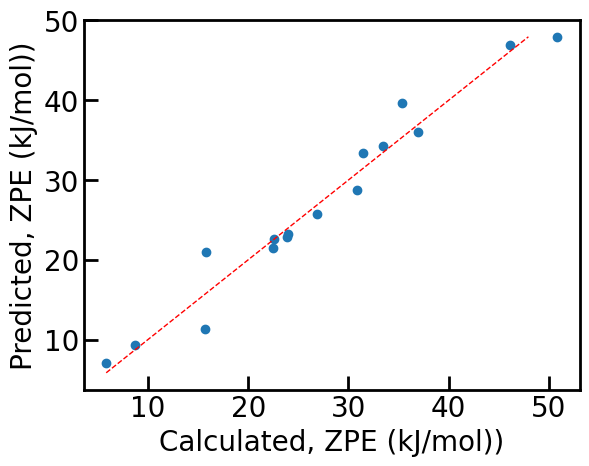

RR 0.9611457784264652
RMSE:  0.20033349473494586
RMSE unscaled:  2.3484302337402823
MAE unscaled:  5.1747785507493
----------------------------------------


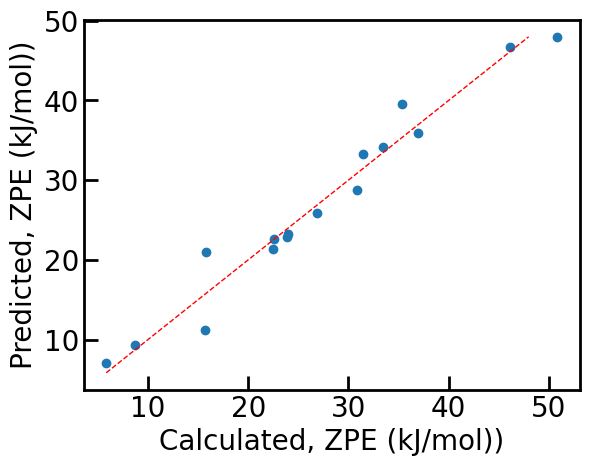

LASSO 0.9481268887467461
RMSE:  0.2314758083568354
RMSE unscaled:  2.7134992450657736
MAE unscaled:  6.383284983442977
----------------------------------------


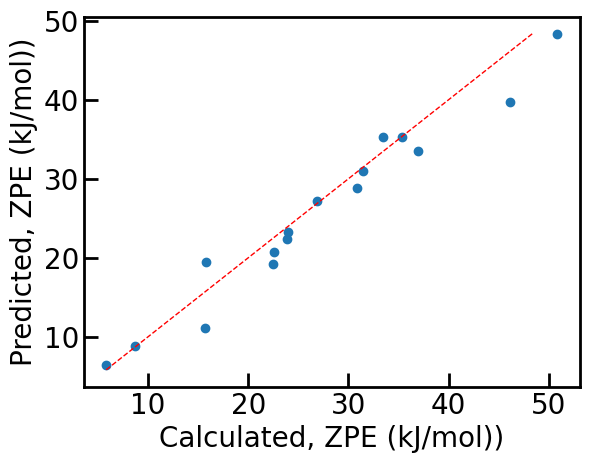

gpr1 0.9630733117452903
RMSE:  0.19530107820869266
RMSE unscaled:  2.2894372074634557
MAE unscaled:  5.028998519373227
----------------------------------------


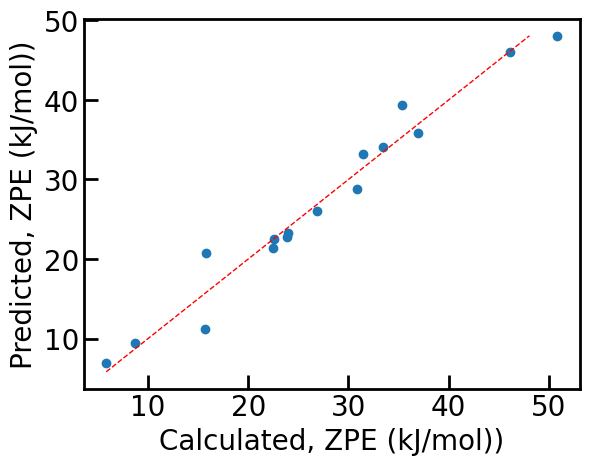

gpr2 0.9568574512009513
RMSE:  0.21109957571961416
RMSE unscaled:  2.474636738133085
MAE unscaled:  4.751176508593915
----------------------------------------


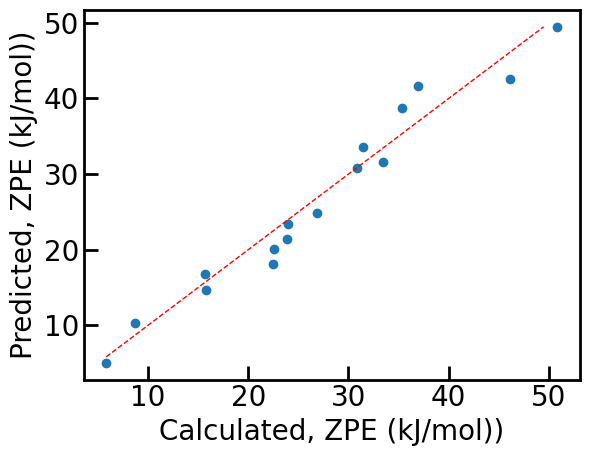

gpr3 0.9568574887274244
RMSE:  0.21109948390973662
RMSE unscaled:  2.474635661882244
MAE unscaled:  4.7511731631406064
----------------------------------------


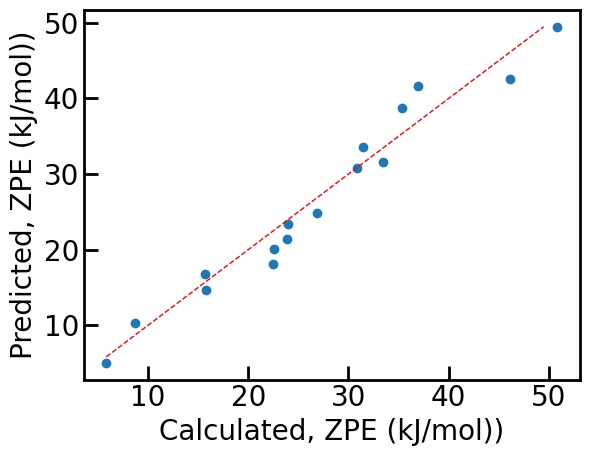

gpr4 0.9568574862747644
RMSE:  0.21109948991025934
RMSE unscaled:  2.4746357322239967
MAE unscaled:  4.751173370889241
----------------------------------------


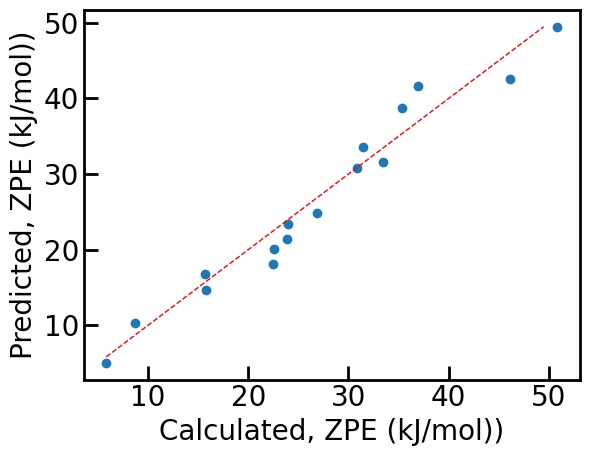

gpr5 0.9598559925528152
RMSE:  0.20363143567327233
RMSE unscaled:  2.387090689491342
MAE unscaled:  4.5230535299129855
----------------------------------------


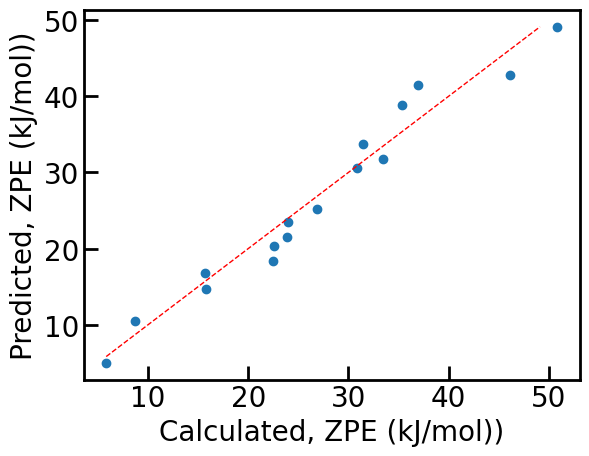

gpr6 0.8983454192975582
RMSE:  0.32403948823657125
RMSE unscaled:  3.7985866123252308
MAE unscaled:  11.68408680223613
----------------------------------------


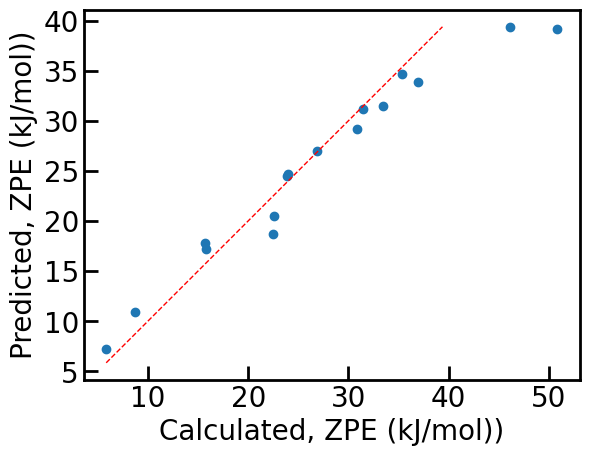

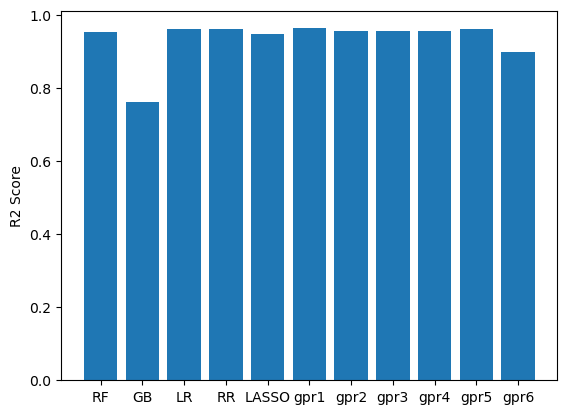

In [20]:
run_models()

In [21]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'Coef_c', 'X_Rvdw', 'X_Z', 'mean_X2X', 'X_G', 'A_Rvdw',
       'A_IEI', 'mean_A2X', 'B_Hf', 'B_Z', 'std_B2X', 'B_Ra', 'A_ChiA',
       'E_coh', 'OF', 'A_EA', 'std_A2X', 'A_ChiP', 'B_MP'], dtype=object)

In [22]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9089623303777756
RMSE:  0.3066514531186606
RMSE unscaled:  3.59475356169001
MAE unscaled:  11.28515164823326
----------------------------------------


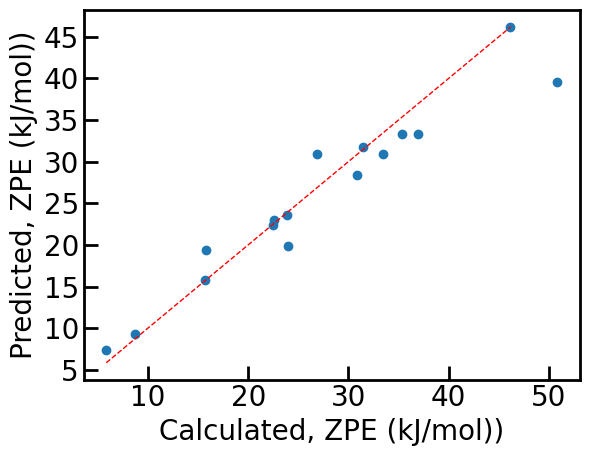

GB 0.7687375477440365
RMSE:  0.48875028559612815
RMSE unscaled:  5.72942607007257
MAE unscaled:  19.458217350406702
----------------------------------------


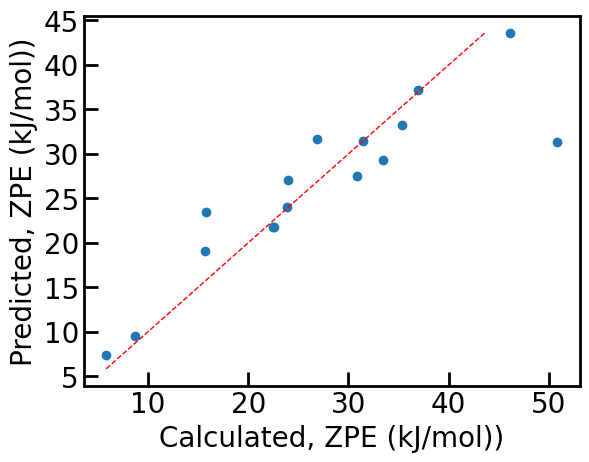

LR 0.943145469839344
RMSE:  0.24233547729449464
RMSE unscaled:  2.8408028439739414
MAE unscaled:  5.934000600235869
----------------------------------------


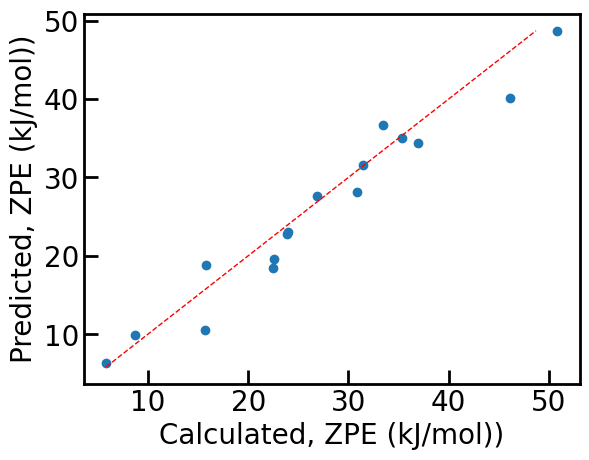

RR 0.9431538994629216
RMSE:  0.24231751150907238
RMSE unscaled:  2.840592238185258
MAE unscaled:  5.93264079086007
----------------------------------------


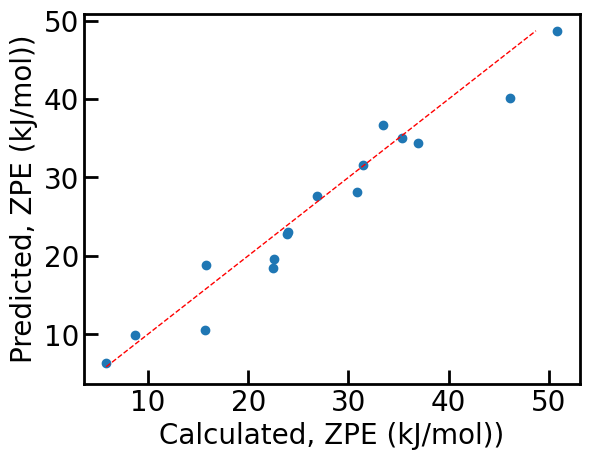

LASSO 0.9425200434531658
RMSE:  0.24366473340100947
RMSE unscaled:  2.8563851869718184
MAE unscaled:  6.573261776588183
----------------------------------------


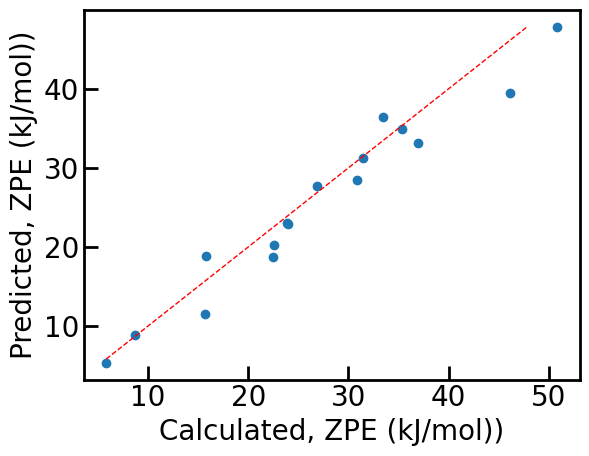

gpr1 0.947351510572085
RMSE:  0.23319939451218505
RMSE unscaled:  2.733704163085272
MAE unscaled:  5.730167172330894
----------------------------------------


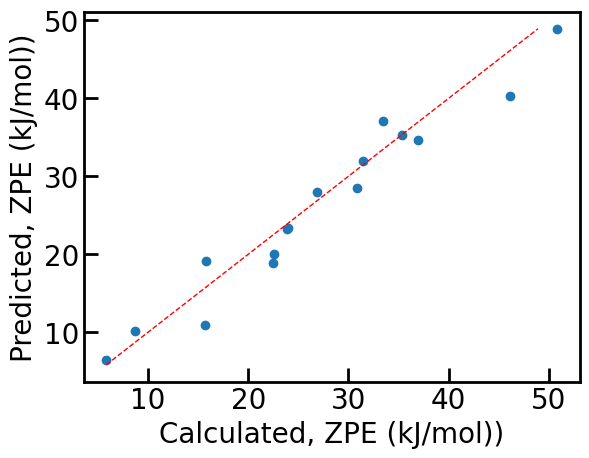

gpr2 0.9506243043435308
RMSE:  0.22583490885807178
RMSE unscaled:  2.6473732138401225
MAE unscaled:  6.0572743621906255
----------------------------------------


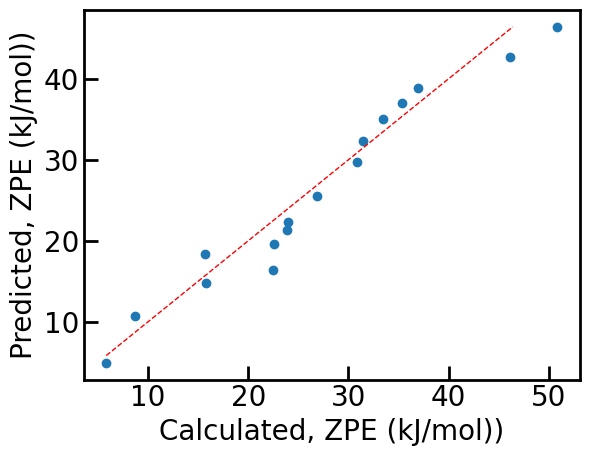

gpr3 0.9506242918977703
RMSE:  0.2258349373203241
RMSE unscaled:  2.6473735474918363
MAE unscaled:  6.057272871173055
----------------------------------------


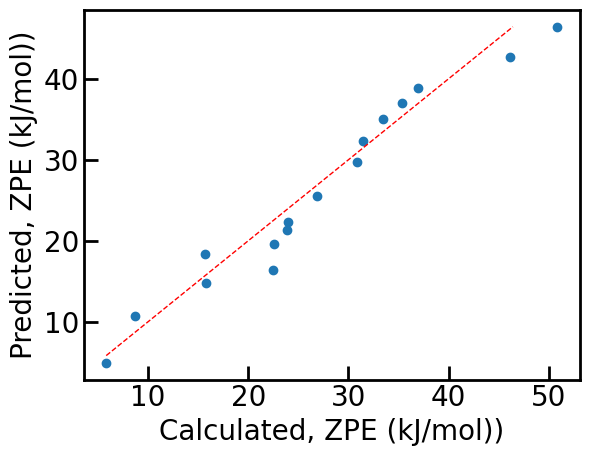

gpr4 0.9506242935232438
RMSE:  0.22583493360302337
RMSE unscaled:  2.647373503915391
MAE unscaled:  6.057273065906941
----------------------------------------


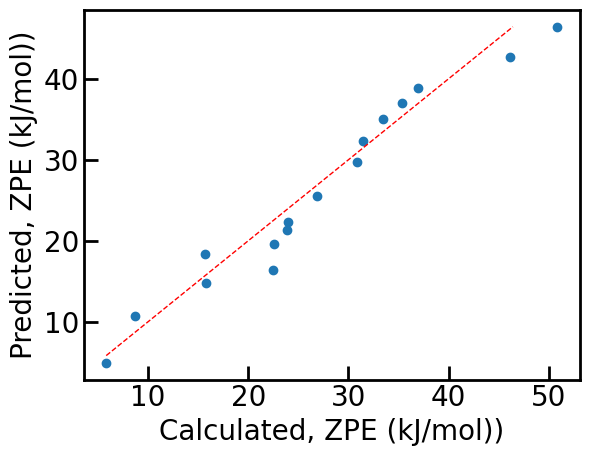

gpr5 0.9508037709325395
RMSE:  0.22542411245405122
RMSE unscaled:  2.6425576102567576
MAE unscaled:  6.41025576264564
----------------------------------------


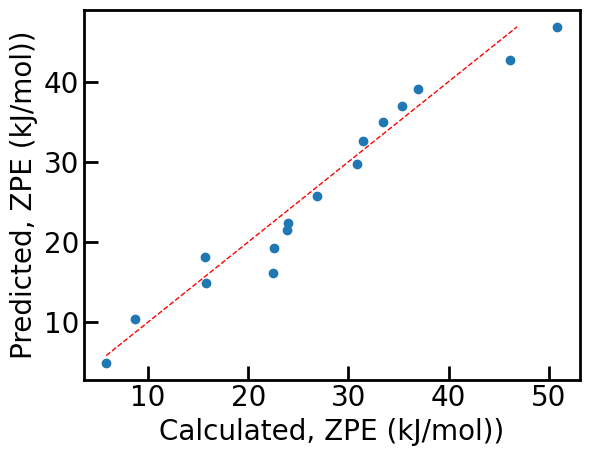

gpr6 0.9443104830396619
RMSE:  0.2398397630231278
RMSE unscaled:  2.811546573786026
MAE unscaled:  7.540442659957812
----------------------------------------


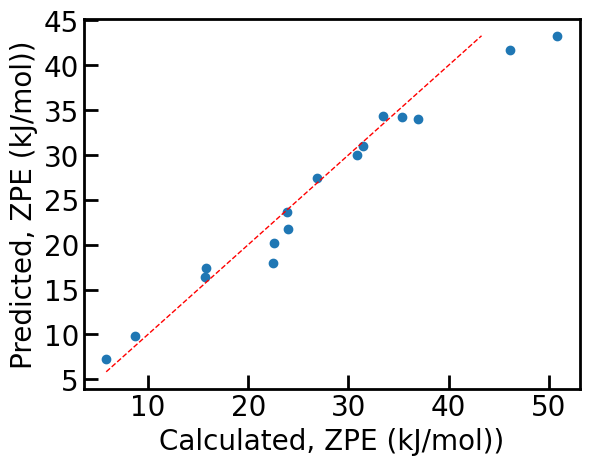

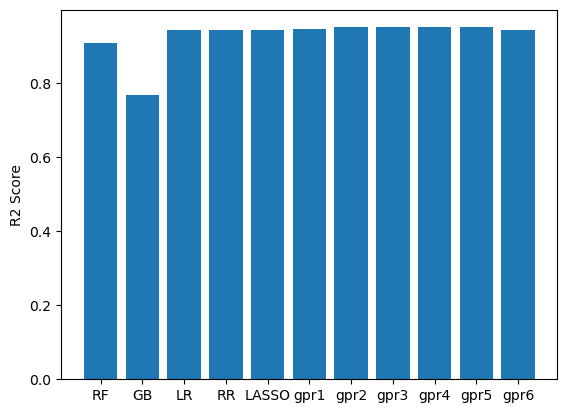

In [23]:
run_models()

In [24]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'Coef_c', 'X_Rvdw', 'X_Z', 'mean_X2X', 'X_G', 'A_Rvdw',
       'A_IEI', 'mean_A2X', 'B_Hf'], dtype=object)

In [25]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.868783281143594
RMSE:  0.3681535968085404
RMSE unscaled:  4.315718839474673
MAE unscaled:  9.797434846458273
----------------------------------------


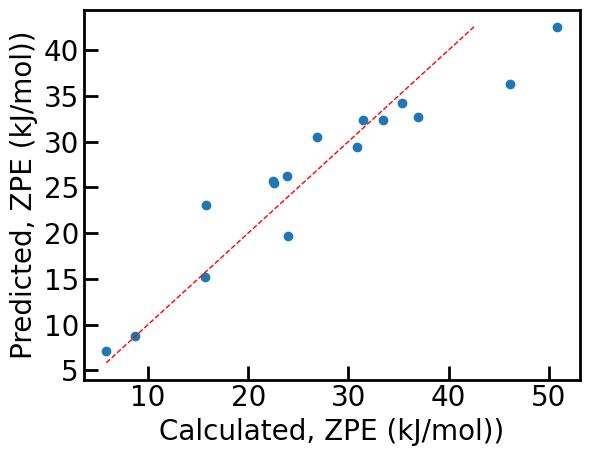

GB 0.61262504807192
RMSE:  0.6325578193254034
RMSE unscaled:  7.415224845241364
MAE unscaled:  23.638505960033086
----------------------------------------


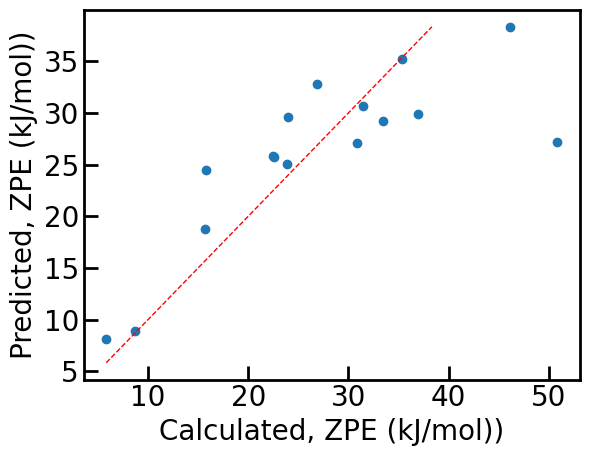

LR 0.8736168168172448
RMSE:  0.36130927123169626
RMSE unscaled:  4.235485520850202
MAE unscaled:  10.630057539165108
----------------------------------------


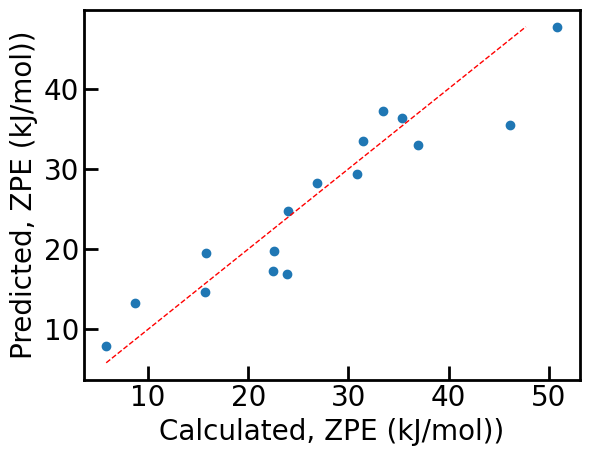

RR 0.8736845389890497
RMSE:  0.36121245484097014
RMSE unscaled:  4.234350580637615
MAE unscaled:  10.630844035069252
----------------------------------------


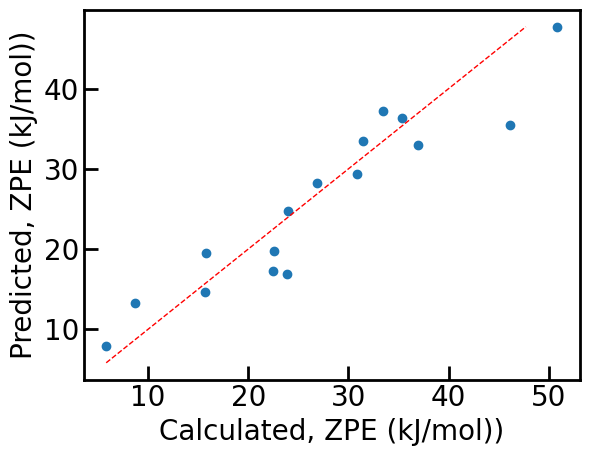

LASSO 0.8743309273493582
RMSE:  0.360287061425531
RMSE unscaled:  4.223502560051759
MAE unscaled:  10.708673735879529
----------------------------------------


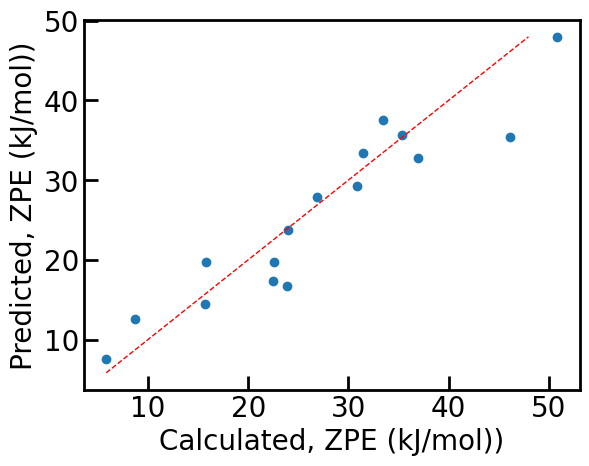

gpr1 0.8767378085990476
RMSE:  0.3568201760750745
RMSE unscaled:  4.182861635853358
MAE unscaled:  10.479061819507471
----------------------------------------


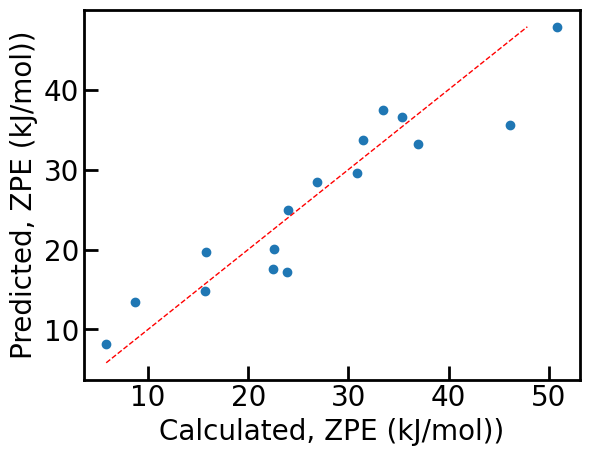

gpr2 0.8922397587693722
RMSE:  0.3336289574805953
RMSE unscaled:  3.911000163179441
MAE unscaled:  10.548116400225325
----------------------------------------


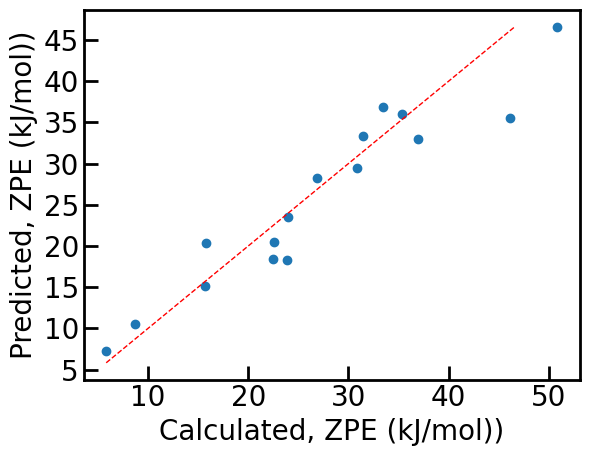

gpr3 -0.0173705668768922
RMSE:  1.0251184393511654
RMSE unscaled:  12.017057553566376
MAE unscaled:  25.569392718958333
----------------------------------------


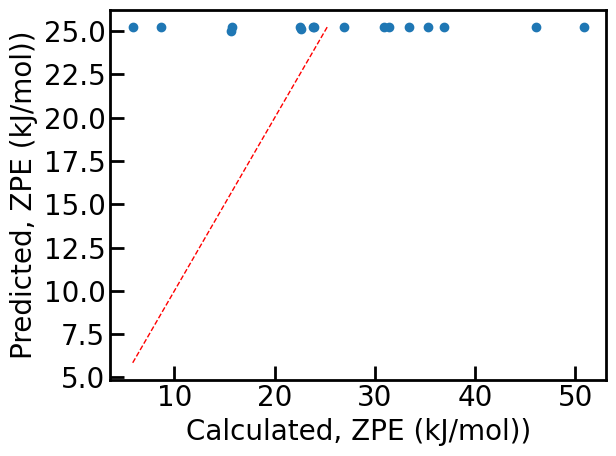

gpr4 0.9256188840582492
RMSE:  0.27718249894082225
RMSE unscaled:  3.2493006805354803
MAE unscaled:  8.609732190978637
----------------------------------------


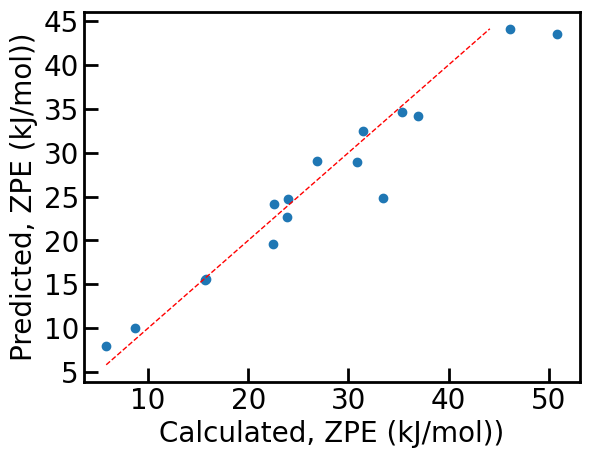

gpr5 0.9624311689236801
RMSE:  0.19699186969687418
RMSE unscaled:  2.309257686585279
MAE unscaled:  6.136816444431105
----------------------------------------


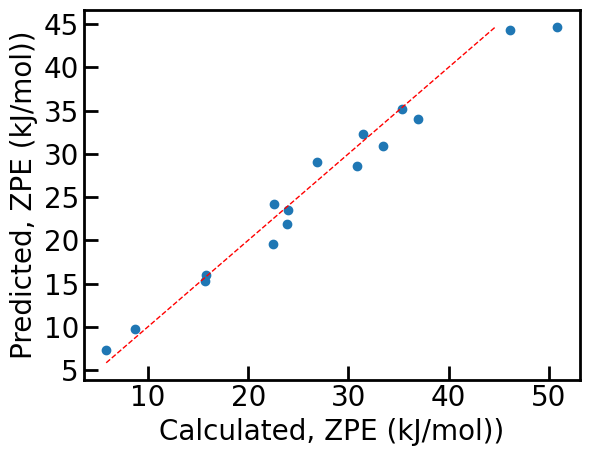

gpr6 0.9277604049596921
RMSE:  0.2731631500849938
RMSE unscaled:  3.2021834454197777
MAE unscaled:  7.093780403491742
----------------------------------------


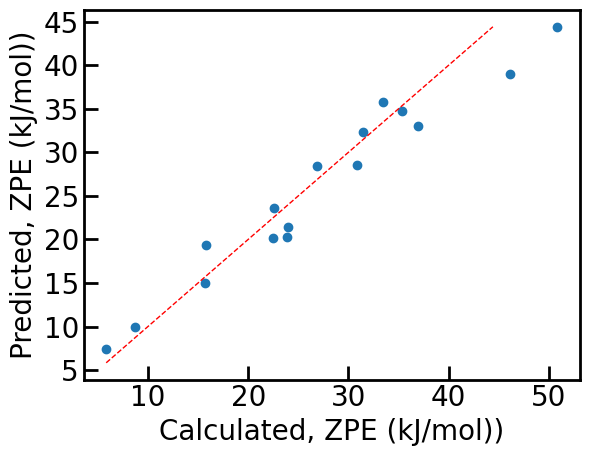

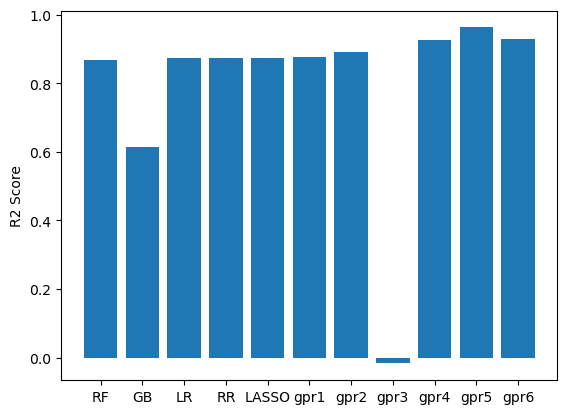

In [26]:
run_models()

# Min-Max scaling

In [27]:
data_std=d.copy()
scaler=MinMaxScaler()
scaler.fit(np.array(data['ZPE']).reshape(-1, 1))
data_zpe_mm= scaler.transform(np.array(data['ZPE']).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std['ZPE'] 
X = data_std.drop(['ZPE'], axis=1)

In [28]:
corrmat = X.corr()
top_corr_features = corrmat.index
correlated_features = set()
#plt.figure(figsize=(20,20))
#plot heat map
#g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn" )

In [29]:
for i in range(len(X.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > 0.9:
            colname = corrmat.columns[i]
            correlated_features.add(colname)
len(correlated_features)
print(correlated_features)

{'X_Ra', 'A_Hf', 'X_Rc', 'B_BP', 'mean_A2B', 'A_BP', 'B_M', 'A_Ra', 'B_Hv', 'X_MendeleevNo', 'X_B', 'A_MendeleevNo', 'A_M', 'X_CvM', 'X_MP', 'X_M', 'X_ChiA', 'A_MV', 'A_Rc', 'X_IEII', 'X_Hv', 'X_BP', 'A_Hv', 'X_Hf'}


In [30]:
data_std.drop(labels=correlated_features, axis=1, inplace=True)
data_std.shape
#data_std.to_csv('scaled_non_corr_all.csv',index=False)

(80, 51)

In [31]:
print(correlated_features)

{'X_Ra', 'A_Hf', 'X_Rc', 'B_BP', 'mean_A2B', 'A_BP', 'B_M', 'A_Ra', 'B_Hv', 'X_MendeleevNo', 'X_B', 'A_MendeleevNo', 'A_M', 'X_CvM', 'X_MP', 'X_M', 'X_ChiA', 'A_MV', 'A_Rc', 'X_IEII', 'X_Hv', 'X_BP', 'A_Hv', 'X_Hf'}


### Test-train splitting 

In [32]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop('ZPE')
X = df_train

Y_test = df_test.pop('ZPE')
X_test = df_test

RF 0.9470490908535545
RMSE:  0.056027380965296726
RMSE unscaled:  2.7415442952978
MAE unscaled:  6.125647562933402
----------------------------------------


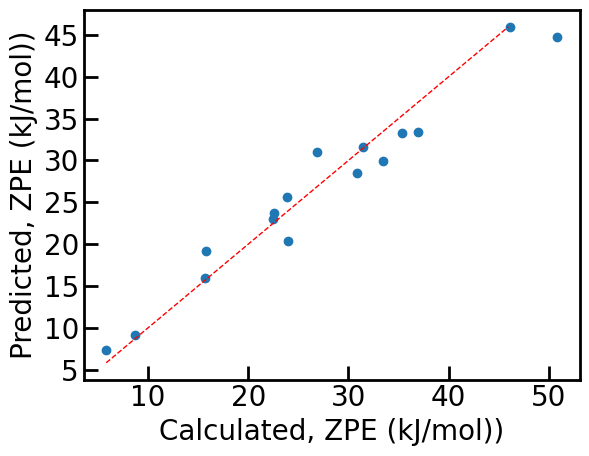

GB 0.8349651491389025
RMSE:  0.09891256030499514
RMSE unscaled:  4.840011450926527
MAE unscaled:  14.148911369444349
----------------------------------------


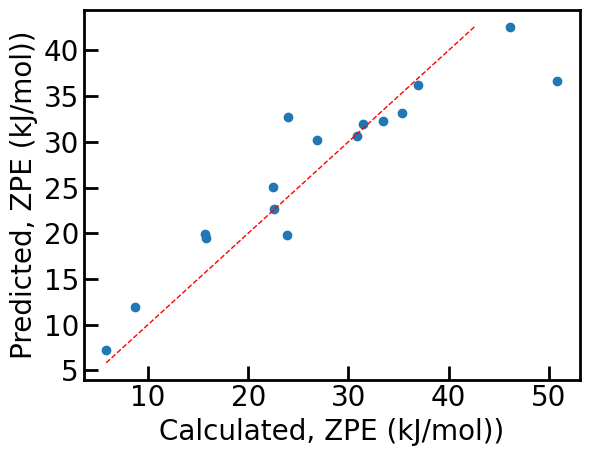

LR 0.9654193000141591
RMSE:  0.04527729793004856
RMSE unscaled:  2.215518835754776
MAE unscaled:  4.509745270473481
----------------------------------------


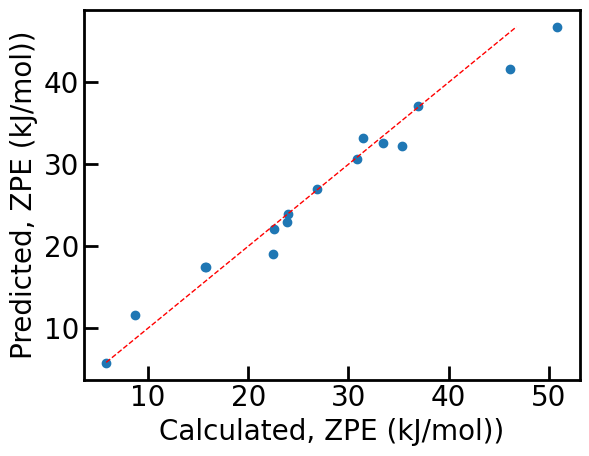

RR 0.9678426279645875
RMSE:  0.04366202621385353
RMSE unscaled:  2.136480000053474
MAE unscaled:  5.8200133001697125
----------------------------------------


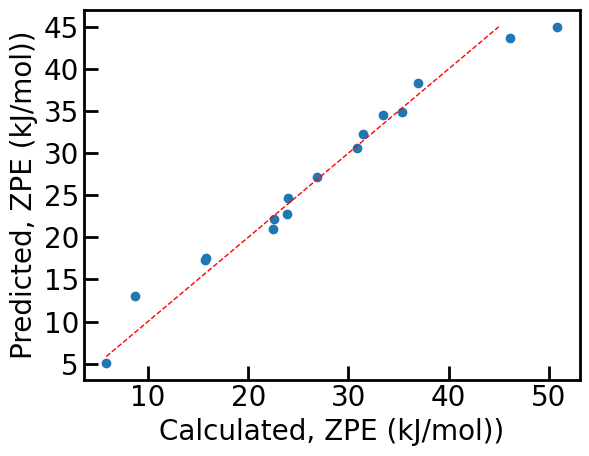

LASSO 0.7924872371791413
RMSE:  0.11091391044552626
RMSE unscaled:  5.427264191403976
MAE unscaled:  12.257879571092559
----------------------------------------


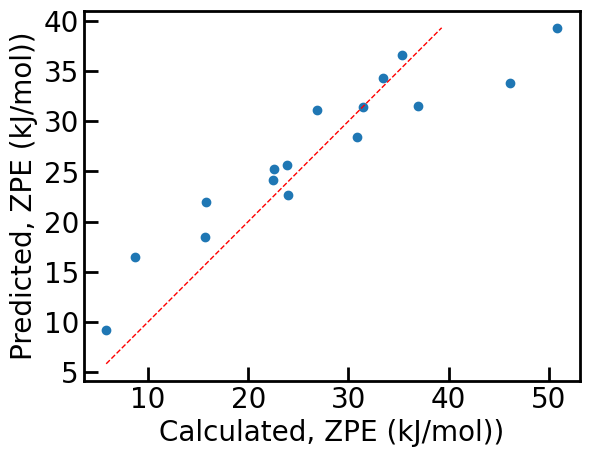

gpr1 0.9703054648724264
RMSE:  0.04195675350577645
RMSE unscaled:  2.0530372157539274
MAE unscaled:  4.715678492160421
----------------------------------------


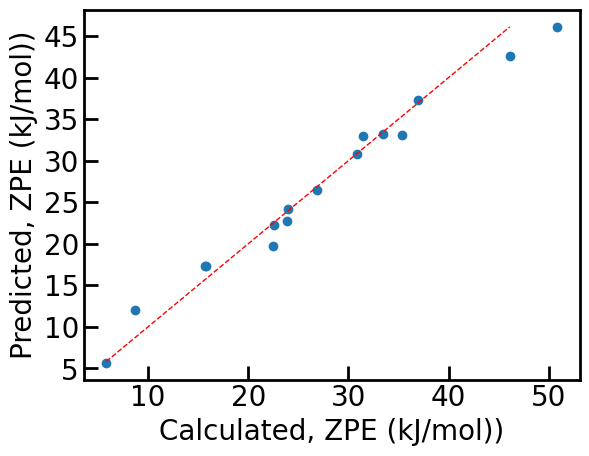

gpr2 0.955995757204555
RMSE:  0.05107529540140803
RMSE unscaled:  2.4992277405419245
MAE unscaled:  4.239549227566982
----------------------------------------


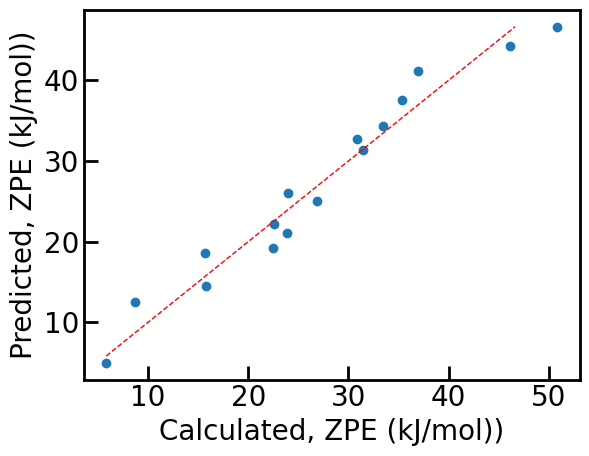

gpr3 0.9559957568214477
RMSE:  0.051075295623742474
RMSE unscaled:  2.4992277514212433
MAE unscaled:  4.2395491595279395
----------------------------------------


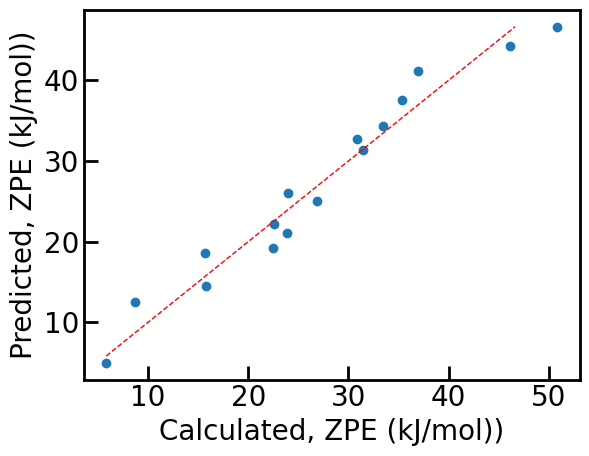

gpr4 0.9559957591265237
RMSE:  0.05107529428600284
RMSE unscaled:  2.499227685962669
MAE unscaled:  4.239549568893409
----------------------------------------


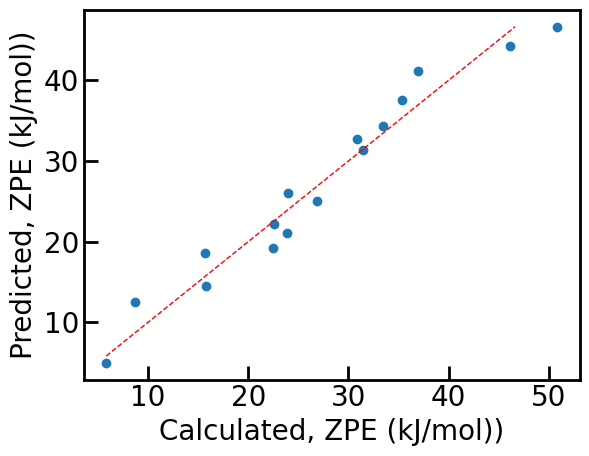

gpr5 0.9654339695562268
RMSE:  0.04526769332860906
RMSE unscaled:  2.2150488612560335
MAE unscaled:  3.739029989479249
----------------------------------------


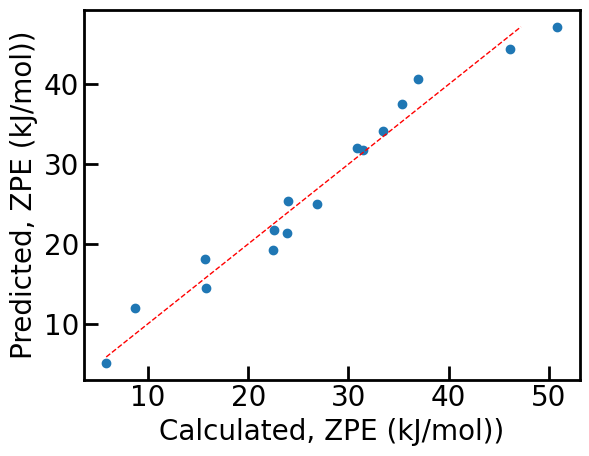

gpr6 0.9078222750223591
RMSE:  0.07392249278697342
RMSE unscaled:  3.6171918962238876
MAE unscaled:  10.371102054322435
----------------------------------------


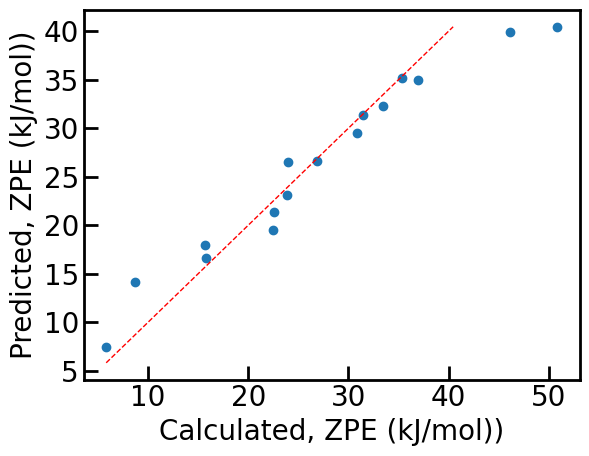

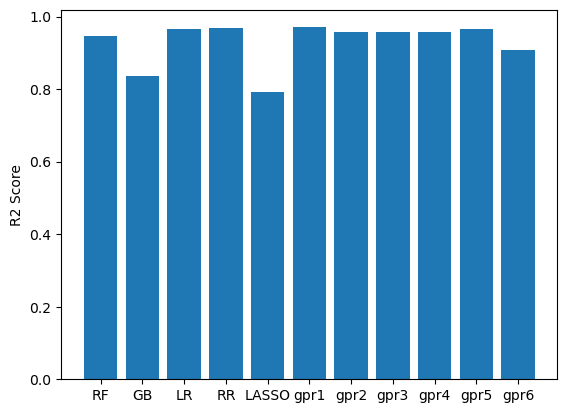

In [33]:
run_models()

## Feature selection


In [34]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
25      X_EA  92.731602
0     Coef_c  78.453631
32    X_Rvdw  78.252722
14       X_Z  56.410866
4   mean_X2X  30.227587
17       X_G  27.028217
30    A_Rvdw  25.470189
18     A_IEI  20.253029
2   mean_A2X  20.187025
41      B_Hf  16.502777
13       B_Z  15.285802
7    std_B2X  13.488784
34      B_Ra  13.013335
29    A_ChiA  12.911391
9      E_coh  12.906501
11        OF  12.359339
23      A_EA  12.040753
6    std_A2X  11.184092
26    A_ChiP   9.894678
36      B_MP   9.555513
38     B_Rho   8.828042
46     B_CvM   7.511897
10        TF   6.732381
42   A_Kappa   6.485563
35      A_MP   6.292825
40      X_MV   5.978844
33      B_Rc   5.532563
31    B_Rvdw   5.346255
8    std_X2X   4.906579
5    std_A2B   4.709590


In [35]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'Coef_c', 'X_Rvdw', 'X_Z', 'mean_X2X', 'X_G', 'A_Rvdw',
       'A_IEI', 'mean_A2X', 'B_Hf', 'B_Z', 'std_B2X', 'B_Ra', 'A_ChiA',
       'E_coh', 'OF', 'A_EA', 'std_A2X', 'A_ChiP', 'B_MP', 'B_Rho',
       'B_CvM', 'TF', 'A_Kappa', 'A_MP', 'X_MV', 'B_Rc', 'B_Rvdw',
       'std_X2X', 'std_A2B'], dtype=object)

In [36]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]
train_csv = pd.concat([X,Y], axis=1, join='inner')
test_csv = pd.concat([X_test,Y_test], axis=1, join='inner')
train_csv.to_csv('ZPE_non_corr_train_30.csv',index=False)
test_csv.to_csv('ZPE_non_corr_test_30.csv',index=False)

RF 0.9497905690313333
RMSE:  0.054557726045988034
RMSE unscaled:  2.669630813163365
MAE unscaled:  5.471514909433537
----------------------------------------


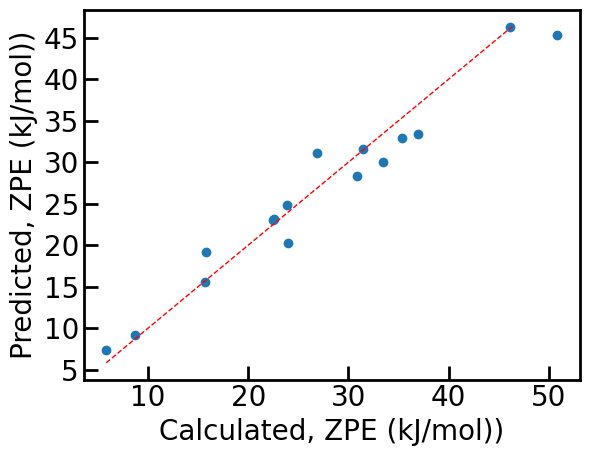

GB 0.8411216532631302
RMSE:  0.09705009547644691
RMSE unscaled:  4.748876906746034
MAE unscaled:  16.01177550999809
----------------------------------------


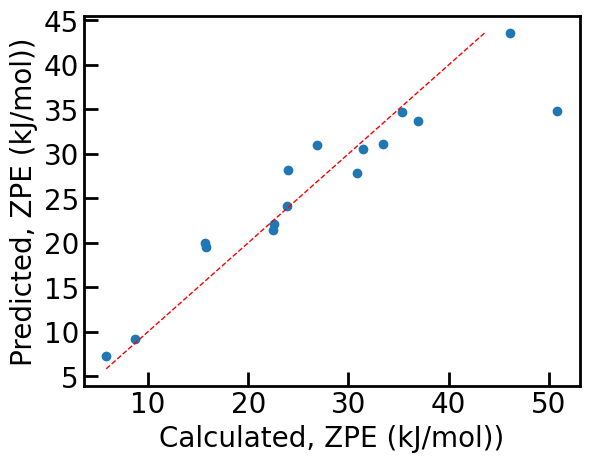

LR 0.9602102523283282
RMSE:  0.048567886340200594
RMSE unscaled:  2.376534641394757
MAE unscaled:  5.240833126649161
----------------------------------------


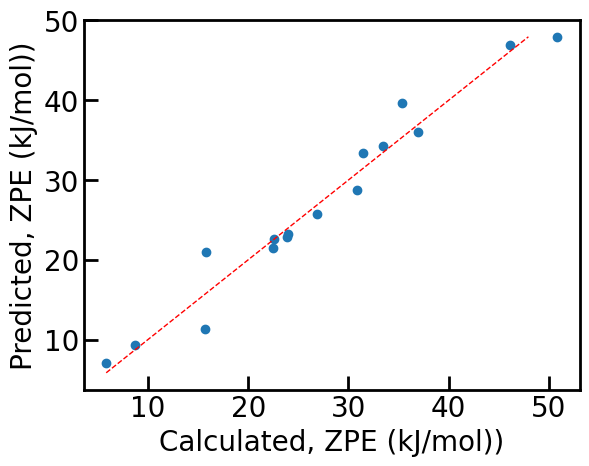

RR 0.9651922591092393
RMSE:  0.04542568967400099
RMSE unscaled:  2.222779973650086
MAE unscaled:  4.422097418607677
----------------------------------------


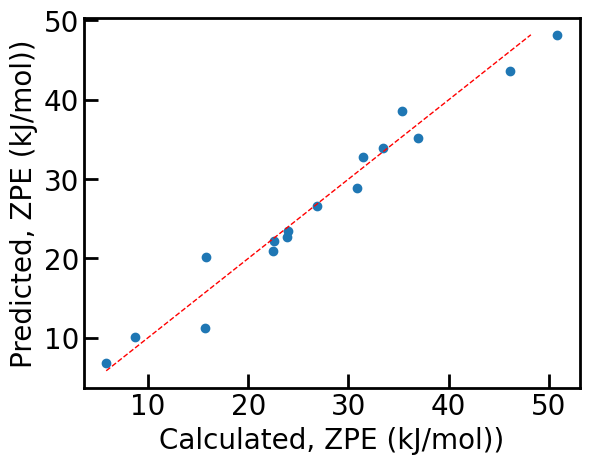

LASSO 0.7924770257692892
RMSE:  0.11091663937036332
RMSE unscaled:  5.427397723762449
MAE unscaled:  12.25792577111919
----------------------------------------


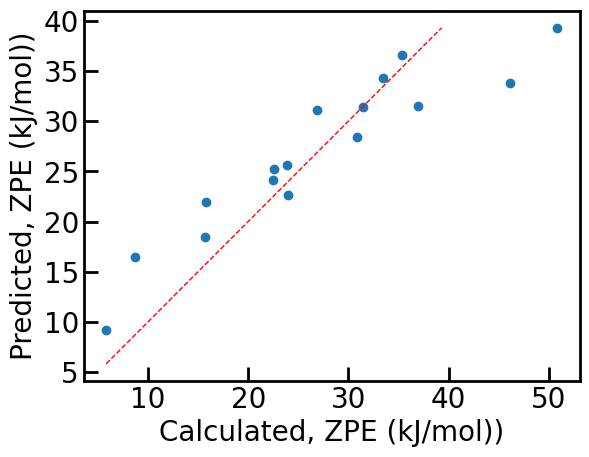

gpr1 0.9646231689488265
RMSE:  0.04579552844005405
RMSE unscaled:  2.240877006596901
MAE unscaled:  4.840652218110339
----------------------------------------


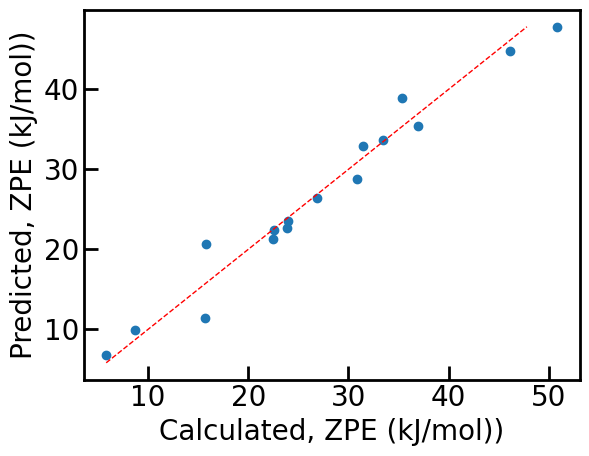

gpr2 0.9633040793085644
RMSE:  0.046641499599674056
RMSE unscaled:  2.2822722559675483
MAE unscaled:  4.092977915835874
----------------------------------------


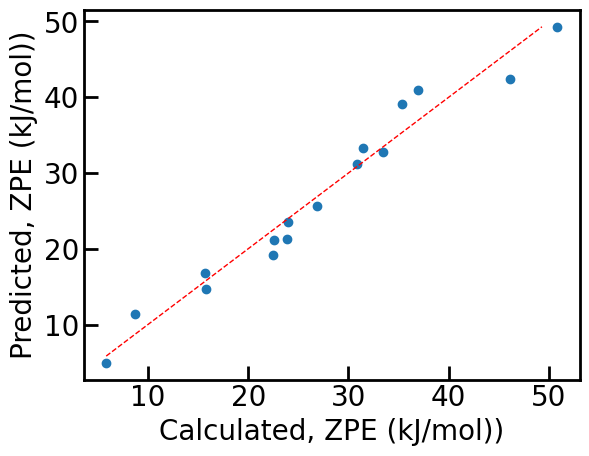

gpr3 0.9633040483738761
RMSE:  0.04664151925907924
RMSE unscaled:  2.2822732179459457
MAE unscaled:  4.0929803607613024
----------------------------------------


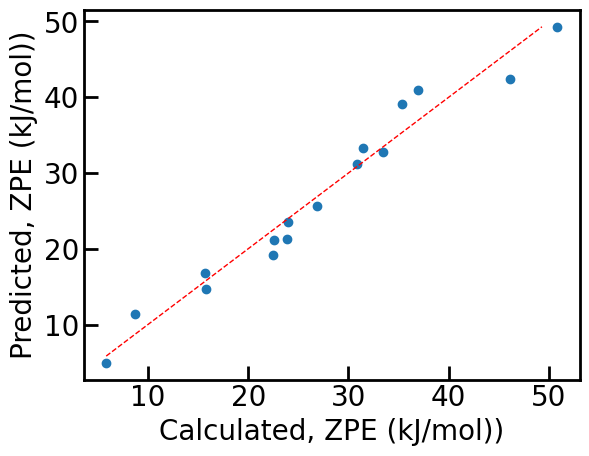

gpr4 0.9633040523386331
RMSE:  0.04664151673942395
RMSE unscaled:  2.2822730946536107
MAE unscaled:  4.092980047405213
----------------------------------------


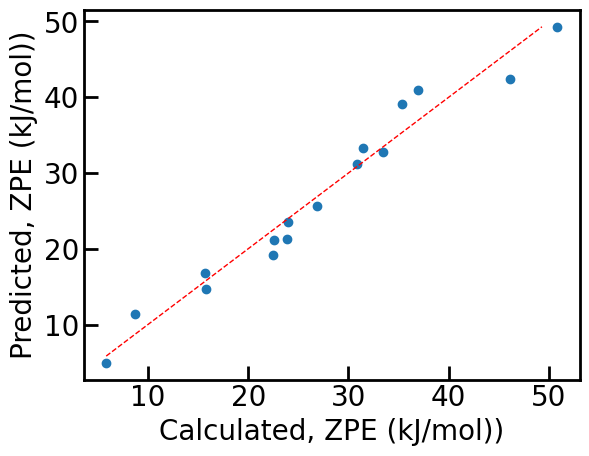

gpr5 0.9669968109518037
RMSE:  0.04423250798186177
RMSE unscaled:  2.1643949411003023
MAE unscaled:  3.531024494791545
----------------------------------------


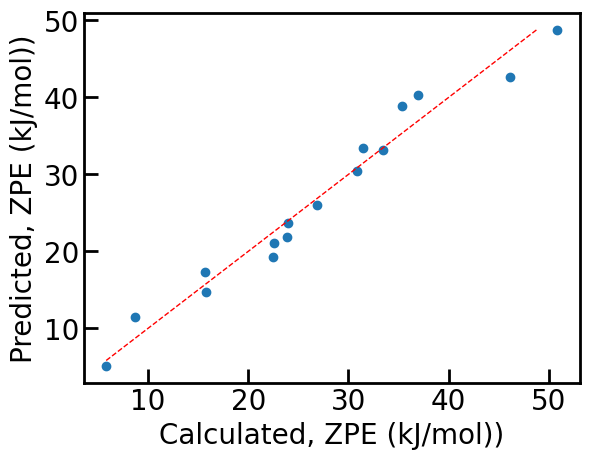

gpr6 0.9277040514771704
RMSE:  0.06546672127750372
RMSE unscaled:  3.2034321997196518
MAE unscaled:  9.438536814793679
----------------------------------------


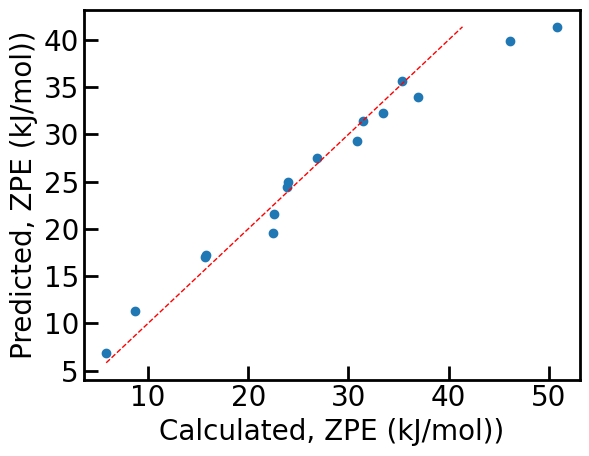

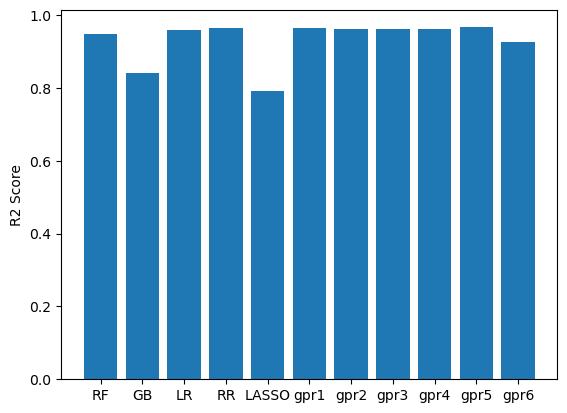

In [37]:
run_models()

In [38]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'Coef_c', 'X_Rvdw', 'X_Z', 'mean_X2X', 'X_G', 'A_Rvdw',
       'A_IEI', 'mean_A2X', 'B_Hf', 'B_Z', 'std_B2X', 'B_Ra', 'A_ChiA',
       'E_coh', 'OF', 'A_EA', 'std_A2X', 'A_ChiP', 'B_MP'], dtype=object)

In [39]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.8689447553460546
RMSE:  0.08814360599952216
RMSE unscaled:  4.3130625781819845
MAE unscaled:  11.601624057308406
----------------------------------------


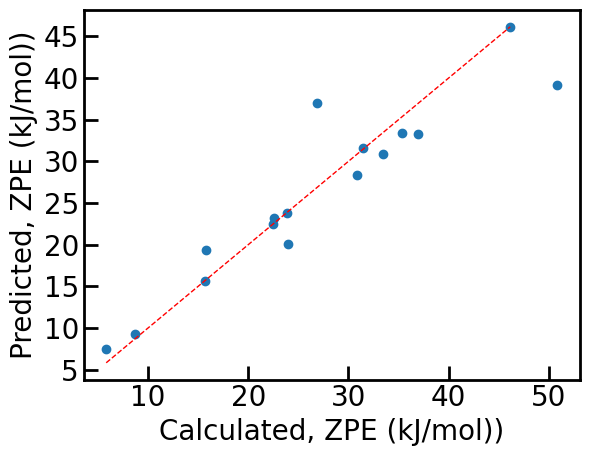

GB 0.783468212794391
RMSE:  0.11329857333601313
RMSE unscaled:  5.543951047562255
MAE unscaled:  17.508685418497187
----------------------------------------


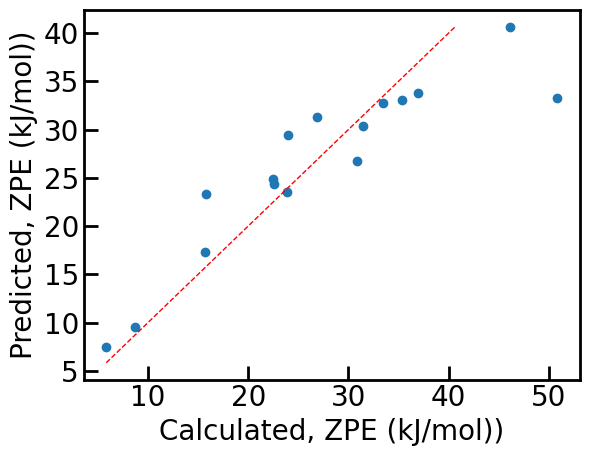

LR 0.9431454698393442
RMSE:  0.05805587145158167
RMSE unscaled:  2.8408028439739366
MAE unscaled:  5.934000600235869
----------------------------------------


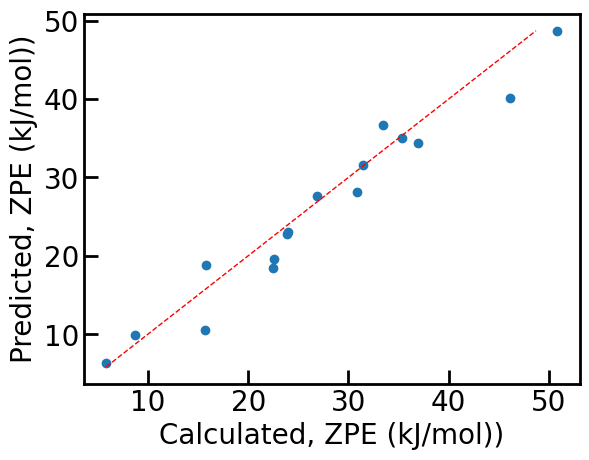

RR 0.9432786750406675
RMSE:  0.05798782164997033
RMSE unscaled:  2.837473015911488
MAE unscaled:  5.894671336598769
----------------------------------------


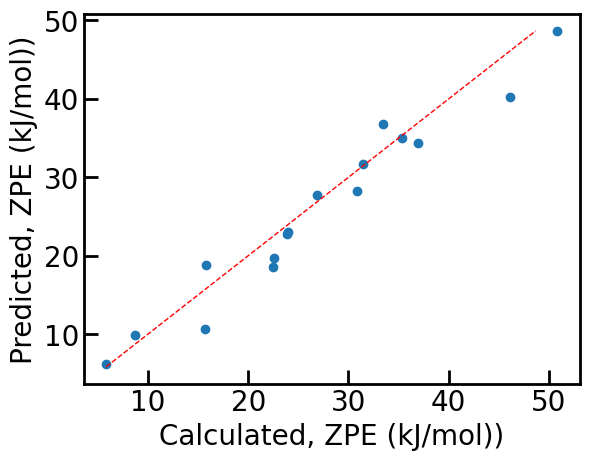

LASSO 0.7924770257692892
RMSE:  0.11091663937036332
RMSE unscaled:  5.427397723762449
MAE unscaled:  12.25792577111919
----------------------------------------


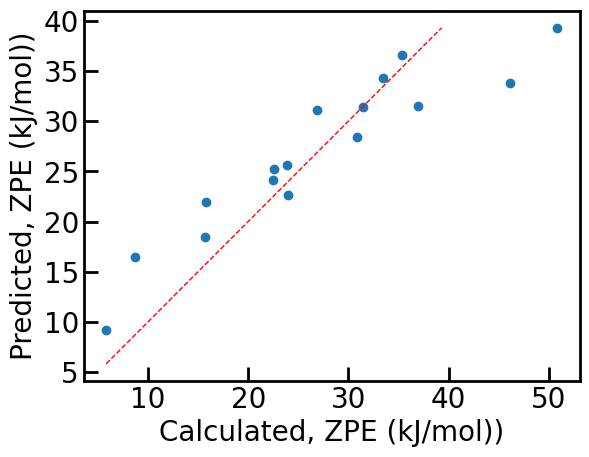

gpr1 0.9427591603410567
RMSE:  0.058252773671136425
RMSE unscaled:  2.8504377072756175
MAE unscaled:  6.040943681249182
----------------------------------------


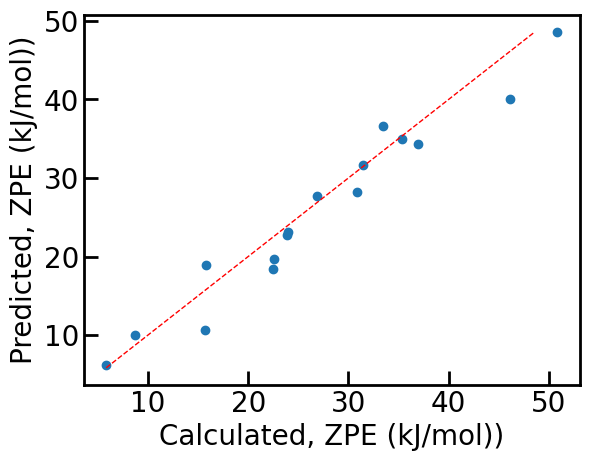

gpr2 0.9577663108816478
RMSE:  0.05003721395018713
RMSE unscaled:  2.4484321075564752
MAE unscaled:  5.242220664698298
----------------------------------------


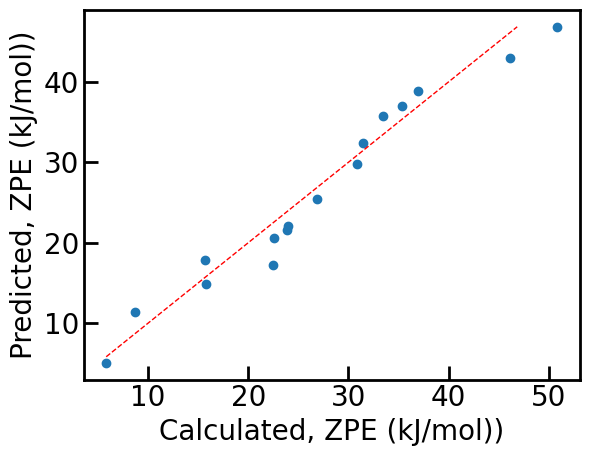

gpr3 0.9577663425113041
RMSE:  0.050037195213247426
RMSE unscaled:  2.4484311907163656
MAE unscaled:  5.2422207188059815
----------------------------------------


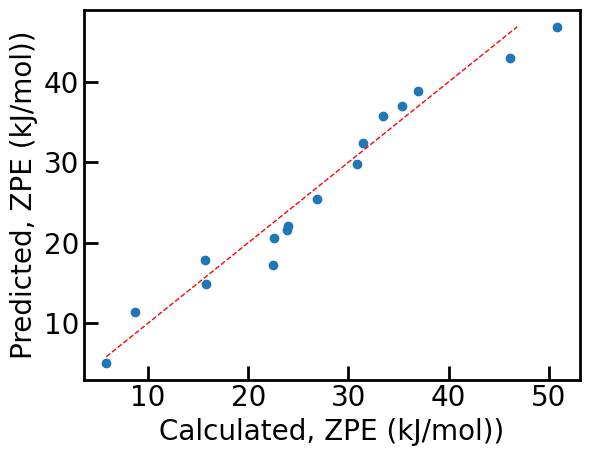

gpr4 0.9577663408543777
RMSE:  0.050037196194786186
RMSE unscaled:  2.448431238745238
MAE unscaled:  5.242220715967832
----------------------------------------


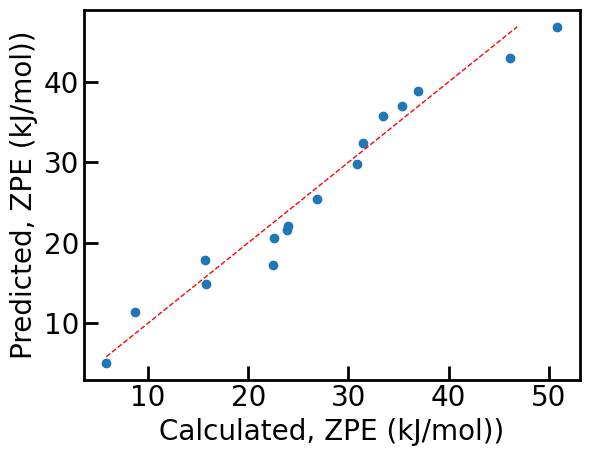

gpr5 0.9556075136860946
RMSE:  0.05130011583279347
RMSE unscaled:  2.5102287040085716
MAE unscaled:  6.201621706673574
----------------------------------------


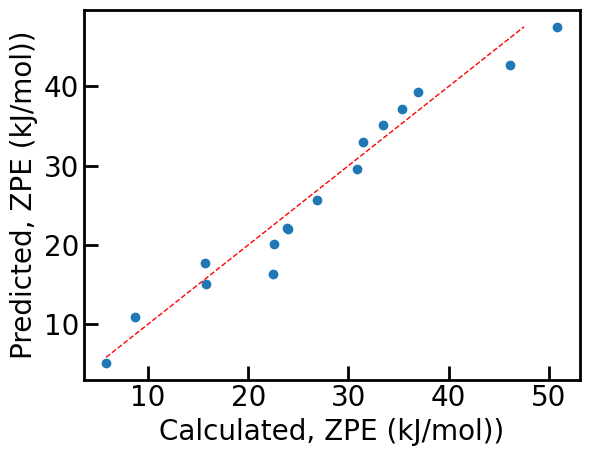

gpr6 0.9453185247630679
RMSE:  0.05693557649032245
RMSE unscaled:  2.785984321187846
MAE unscaled:  7.610537052591226
----------------------------------------


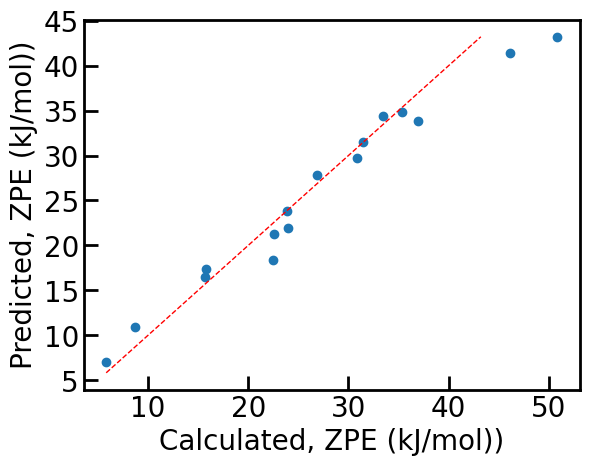

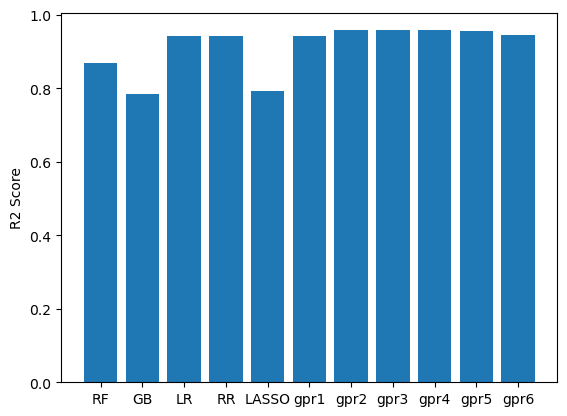

In [40]:
run_models()

In [41]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'Coef_c', 'X_Rvdw', 'X_Z', 'mean_X2X', 'X_G', 'A_Rvdw',
       'A_IEI', 'mean_A2X', 'B_Hf'], dtype=object)

In [42]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8724158416788034
RMSE:  0.08696850157223114
RMSE unscaled:  4.255562106385626
MAE unscaled:  9.641880900924818
----------------------------------------


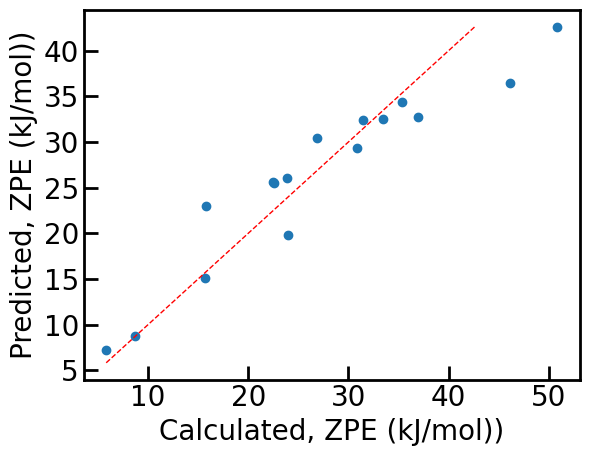

GB 0.6271904092329704
RMSE:  0.1486644570783993
RMSE unscaled:  7.274482354784326
MAE unscaled:  23.296995685466147
----------------------------------------


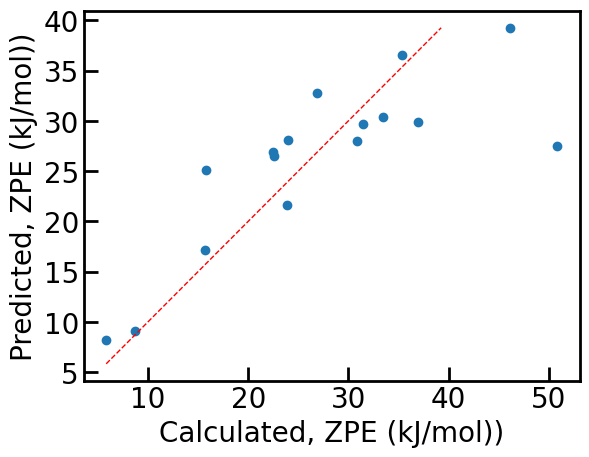

LR 0.8736168168172446
RMSE:  0.08655820781618837
RMSE unscaled:  4.235485520850205
MAE unscaled:  10.630057539165108
----------------------------------------


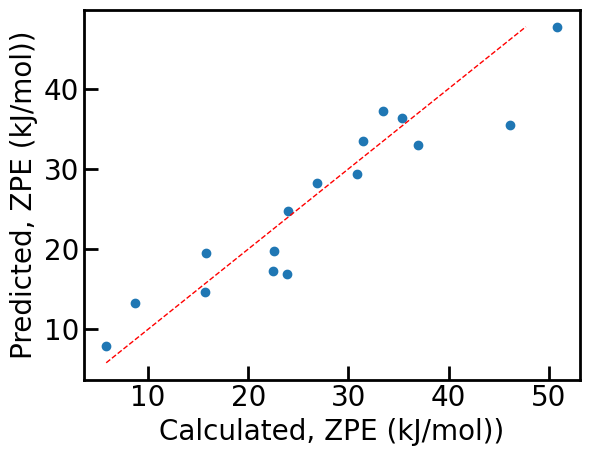

RR 0.8745553691686371
RMSE:  0.08623620770511715
RMSE unscaled:  4.2197293396333935
MAE unscaled:  10.649468917884015
----------------------------------------


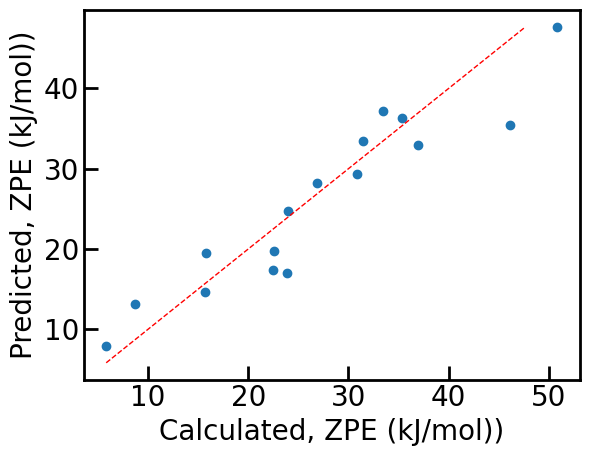

LASSO 0.7793957769438237
RMSE:  0.11435904552807209
RMSE unscaled:  5.595842309269847
MAE unscaled:  14.817673737292928
----------------------------------------


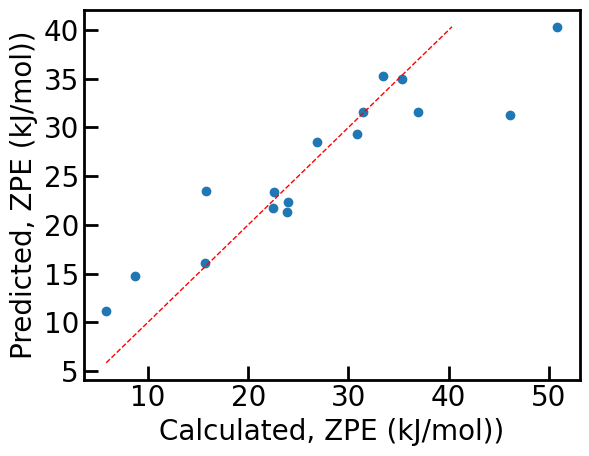

gpr1 0.8728178503768593
RMSE:  0.08683137765810818
RMSE unscaled:  4.248852328451414
MAE unscaled:  10.609392644045002
----------------------------------------


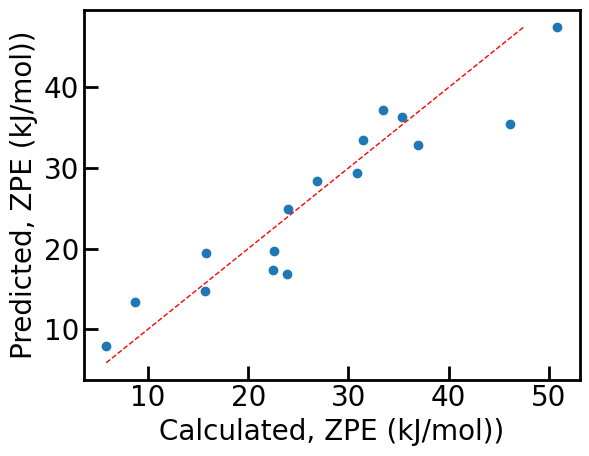

gpr2 0.8880969789390157
RMSE:  0.08144876746780078
RMSE unscaled:  3.985469246700914
MAE unscaled:  10.502435591097324
----------------------------------------


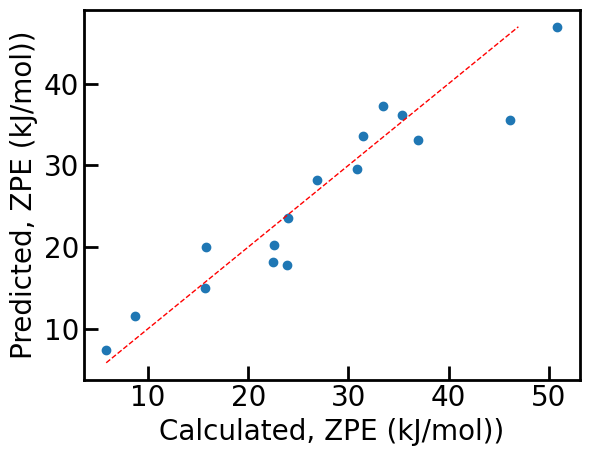

gpr3 0.9007398692588824
RMSE:  0.07670983214595214
RMSE unscaled:  3.753582607105061
MAE unscaled:  9.163493673513049
----------------------------------------


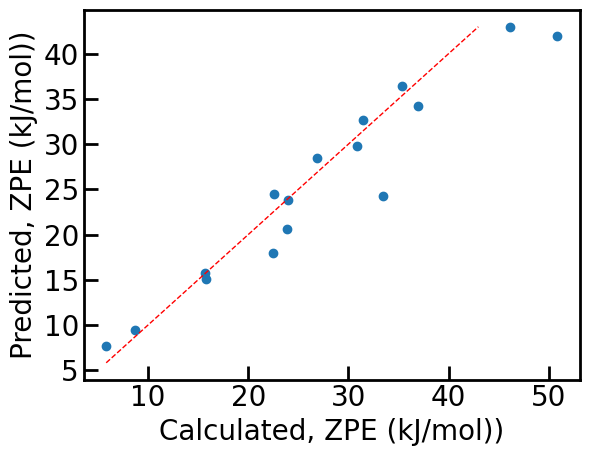

gpr4 0.9007398614372443
RMSE:  0.0767098351682962
RMSE unscaled:  3.7535827549950738
MAE unscaled:  9.163494701929299
----------------------------------------


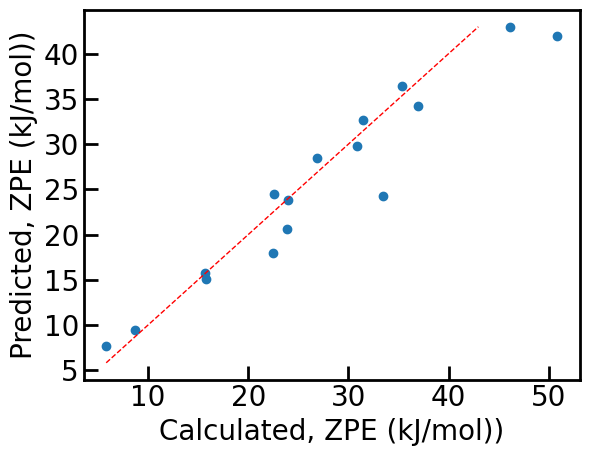

gpr5 0.9520888653532105
RMSE:  0.053294432131635316
RMSE unscaled:  2.6078150337264625
MAE unscaled:  6.2948097177796924
----------------------------------------


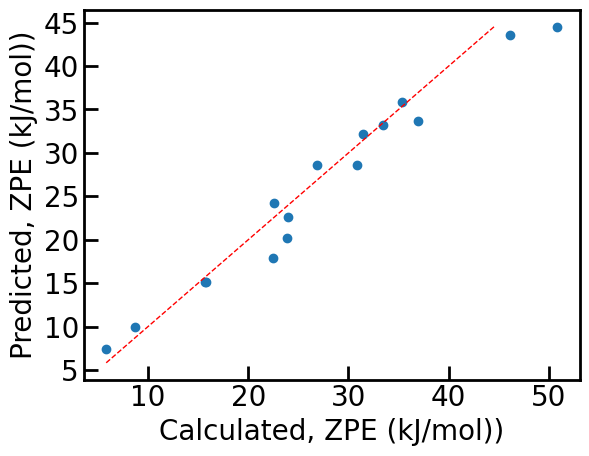

gpr6 0.9205973375264629
RMSE:  0.06860900855804884
RMSE unscaled:  3.357191301425677
MAE unscaled:  7.795150043086849
----------------------------------------


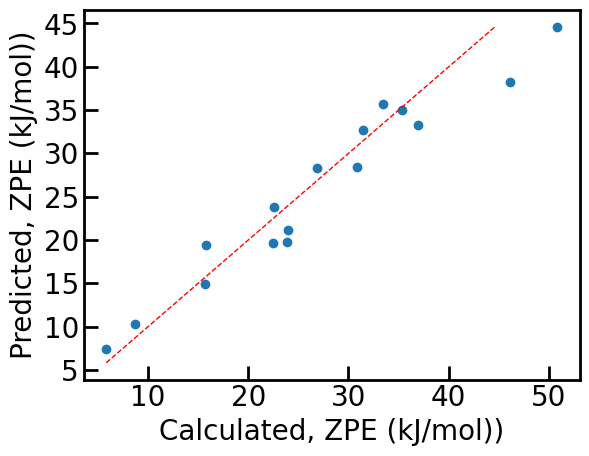

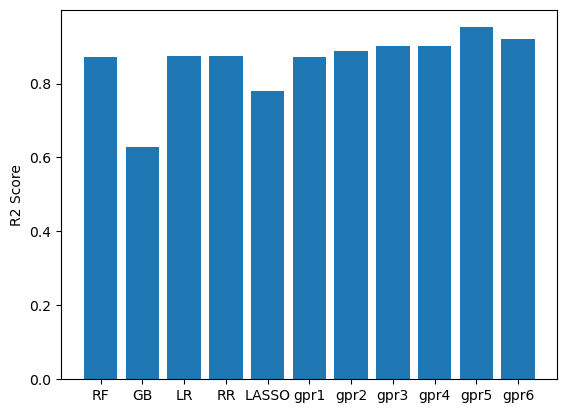

In [43]:
run_models()